In [1]:
from quspin.operators import hamiltonian,exp_op,quantum_operator # Hamiltonians and operators
from quspin.basis import spinless_fermion_basis_1d, spin_basis_1d # Hilbert space fermion basis
from quspin.tools.block_tools import block_diag_hamiltonian # block diagonalisation
from quspin.tools.measurements import ED_state_vs_time
from quspin.tools.evolution import expm_multiply_parallel
from scipy.optimize import minimize_scalar,minimize,basinhopping, shgo, differential_evolution
import numpy as np # generic math functions
import numba as nb
import matplotlib.pyplot as plt # plotting library
import copy
import matplotlib.pyplot as pl
import scipy
from scipy import sparse, interpolate
import sys,os

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ['OMP_NUM_THREADS']='16' # set number of OpenMP threads to run in parallel
os.environ['MKL_NUM_THREADS']='16' # set number of MKL threads to run in parallel
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)

In [3]:
L=18
#m=1.0471975511965976
m=0.8
g=1
a=1
hop=1
r=0.4
layers=int(L/2)
psi=np.zeros(2**L,dtype=np.complex128)
vac=np.zeros(2**L,dtype=np.complex128)
charge=int(L/2)
length=int(np.math.factorial(L)/(np.math.factorial(L-charge)*np.math.factorial(charge)))

In [4]:
def bins(n,L):
    bins=[str(int(j)) for j in bin(n)[2:]]
    bins=''.join(bins)
    l=L-len(bins)
    zbins=[str(0) for x in range (0,l)]
    zbins=''.join(zbins)
    zbins=''.join([zbins,bins])
    return zbins

def counting(state):
    odd=0
    even=0
    positionF=[]
    positionAF=[]
    num=list(state)
    for i in range(0,len(num),2):
        if num[i]=="1":
            positionF.append(int(i/2))
            even=even+1
    for i in range(1,len(num)+1,2):
        if num[i]=="0":
            positionAF.append(int((i-1)/2))
            odd=odd+1
    return even,odd,positionF,positionAF

In [5]:
def sigma(sym,pos):
    basis=spin_basis_1d(L=L,pauli=-1)
    sigma_list=[[1,pos]]
    static_sigma=[[sym,sigma_list]]
    sigma=hamiltonian(static_sigma,dynamic,basis=basis,dtype=np.complex128,check_symm=False, check_herm=False, check_pcon=False)
    return sigma

In [6]:
#boundary term of ham
def boundary(sym_i,sym_j,i,j):
    string=[]
    pos=[]
    string.append(sym_i)
    for k in range(i+1,j):
        string.append('z')
    string.append(sym_j)
    string=''.join(string)
    for k in range(i,j+1):
        pos.append(k)
    return string,pos

In [7]:
#set the H=H1+...+H4
basis1=spin_basis_1d(L=L,pauli=-1)
hyx_even=[[-1/4,2*i,2*i+1] for i in range(int(L/2))]
hxy_even=[[1/4,2*i,2*i+1] for i in range(int(L/2))]
hyx_odd=[[-1/4,2*i+1,2*i+2] for i in range(int(L/2)-1)]
hxy_odd=[[1/4,2*i+1,2*i+2] for i in range(int(L/2)-1)]
boundary_term1=[[-1/4]+boundary('x','y',0,L-1)[1]]
boundary_term2=[[1/4]+boundary('y','x',0,L-1)[1]]
hzz=[[g/2,2*i,2*i+1] for i in range(int(L/2))]
hz=[[-(m/2+r/2)*(-1)**i,i] for i in range(L)]
hI=[[-g/2,2*i] for i in range(int(L/2))]
hWxx_even=[[-r/4,2*i,2*i+1,2*i+2] for i in range(int(L/2)-1)]
hWxx_odd=[[r/4,2*i+1,2*i+2,2*i+3] for i in range(int(L/2)-1)]
#hWz=[[-(-1)**i*r/2,i] for i in range(L)]
hWb1=[[-r/4]+boundary('x','x',0,L-2)[1]]
hWb2=[[r/4]+boundary('x','x',1,L-1)[1]]
static_hxyeven=[['yx',hyx_even],['xy',hxy_even],['xzx',hWxx_even],['yzy',hWxx_even],[boundary('x','x',0,L-2)[0],hWb1],[boundary('y','y',0,L-2)[0],hWb1]]
static_hxyodd=[['yx',hyx_odd],['xy',hxy_odd],['xzx',hWxx_odd],['yzy',hWxx_odd],[boundary('x','x',1,L-1)[0],hWb2],[boundary('y','y',1,L-1)[0],hWb2],[boundary('x','y',0,L-1)[0],boundary_term1],[boundary('y','x',0,L-1)[0],boundary_term2]]
static_hzz=[['zz',hzz]]
static_hz=[['z',hz]]
static_hI=[['I',hI]]
#static_hW=[['xzx',hWxx],['yzy',hWyy],['z',hWz],[boundary('x','x',0,L-2)[0],hWb1],[boundary('y','y',0,L-2)[0],hWb1],[boundary('x','x',1,L-1)[0],hWb2],[boundary('y','y',1,L-1)[0],hWb2]]
static_ham=static_hxyeven+static_hxyodd+static_hzz+static_hz+static_hI#+static_hW
dynamic=[]
hxyodd=hamiltonian(static_hxyodd,dynamic,basis=basis1,dtype=np.complex128)
hxyeven=hamiltonian(static_hxyeven,dynamic,basis=basis1,dtype=np.complex128)
hzz=hamiltonian(static_hzz,dynamic,basis=basis1,dtype=np.complex128)#*(1/g)
hz=hamiltonian(static_hz,dynamic,basis=basis1,dtype=np.complex128)
ham=hamiltonian(static_ham,dynamic,basis=basis1,dtype=np.complex128)

Hermiticity check passed!


C:\Users\shilong\AppData\Local\Temp\ipykernel_45332\1621243830.py:25: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  hxyodd=hamiltonian(static_hxyodd,dynamic,basis=basis1,dtype=np.complex128)


Hermiticity check passed!


C:\Users\shilong\AppData\Local\Temp\ipykernel_45332\1621243830.py:26: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  hxyeven=hamiltonian(static_hxyeven,dynamic,basis=basis1,dtype=np.complex128)


Hermiticity check passed!


C:\Users\shilong\AppData\Local\Temp\ipykernel_45332\1621243830.py:27: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  hzz=hamiltonian(static_hzz,dynamic,basis=basis1,dtype=np.complex128)#*(1/g)


Hermiticity check passed!


C:\Users\shilong\AppData\Local\Temp\ipykernel_45332\1621243830.py:28: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  hz=hamiltonian(static_hz,dynamic,basis=basis1,dtype=np.complex128)


Hermiticity check passed!


C:\Users\shilong\AppData\Local\Temp\ipykernel_45332\1621243830.py:29: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  ham=hamiltonian(static_ham,dynamic,basis=basis1,dtype=np.complex128)


In [8]:
E0,V0=ham.eigsh(which='SA',k=1)

In [9]:
basis2=spin_basis_1d(L=L,Nup=int(L/2),pauli=-1)
sub_ham=hamiltonian(static_ham,dynamic,basis=basis2,dtype=np.complex128)

Hermiticity check passed!
Particle conservation check passed!


C:\Users\shilong\AppData\Local\Temp\ipykernel_45332\3221134857.py:2: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  sub_ham=hamiltonian(static_ham,dynamic,basis=basis2,dtype=np.complex128)


In [10]:
p=1
E,V=sub_ham.eigsh(which='SA',k=2)
for i in range(length):
    psi[2**L-1-basis2[i]]=V[:,p][i]
    vac[2**L-1-basis2[i]]=V[:,0][i]

In [11]:
eng=[]
for i in range(len(E)):
    eng.append(E[i]-E[0])
print(eng)

[0.0, 2.37955607692286]


In [12]:
def psi0():
    ini_state1=np.zeros((2**L,1),dtype=np.complex128)[:,0]
    ini_state2=np.zeros((2**L,1),dtype=np.complex128)[:,0]
    for i in range(2**(L)):
        if counting(bins(2**L-1-i,L))[0]==1 and counting(bins(2**L-1-i,L))[1]==1 and counting(bins(2**L-1-i,L))[2]==counting(bins(2**L-1-i,L))[3]:
            ini_state1[i]=1
        if counting(bins(2**L-1-i,L))[0]==0 and counting(bins(2**L-1-i,L))[1]==0:
            ini_state2[i]=1
    
    ini_state1=ini_state1/np.linalg.norm(ini_state1)
    return ini_state2,ini_state1

In [13]:
def QAOA_state(psi0,layers,parameters):
    evo=[]
    for i in range(layers):
        evo.append(expm_multiply_parallel(hxyeven.tocsr(),a=-1j*parameters[4*i],dtype=dtype_cmplx))
        evo.append(expm_multiply_parallel(hzz.tocsr(),a=-1j*parameters[4*i+1],dtype=dtype_cmplx))
        evo.append(expm_multiply_parallel(hxyodd.tocsr(),a=-1j*parameters[4*i+2],dtype=dtype_cmplx))
        evo.append(expm_multiply_parallel(hz.tocsr(),a=-1j*parameters[4*i+3],dtype=dtype_cmplx))
    for i in range(len(parameters)):
        psi0=evo[i].dot(psi0)
    eng=np.real(np.dot(np.conjugate(psi0),ham.dot(psi0)))
    return psi0,eng

In [14]:
psi1=psi0()[0]
psi2=psi0()[1]
def object_fun(parameters):
    fun=QAOA_state(psi1,layers,parameters)[1]+0.5*QAOA_state(psi2,layers,parameters)[1]
    return fun

In [15]:
def VQE():
    #params = np.zeros((1,4*layers))[0]
    params = np.random.rand(4*layers)
    #params = [1.5874826181603343, -5.764980554229284, 3.180451162142225, 0.7801325877748178, 1.821616907196922, -0.002245791631400766, 5.76816210716024, -1.566612409007393, 1.5045064941759985, 0.0021317067796131346, 3.159105695760915, -0.028697078164330293, 4.088198767433721, 0.0167910172839104, 0.5638924594820393, 0.7838691686051756, 1.9507594097009515, 1.0293042445602825, 0.3953247774571321, 0.7840586777043385]
    optimizer = scipy.optimize.minimize(fun=object_fun, x0=params, method='BFGS', options={'gtol': 1e-05, 'eps': 1e-08, 'disp': True})
    return optimizer.x.tolist()

In [16]:
aa=VQE()

In [ ]:
print(aa)

NameError: name 'aa' is not defined

In [ ]:
print(-QAOA_state(psi1,layers,aa)[1]+QAOA_state(psi2,layers,aa)[1])

2.941578490398417


file_VQE_qqbar_para=open('/home/lty/胤/code_for_SCNU_super_computer/PDF_NJL/VQE_qqbar_para/quspinhz_L14m13464g08.txt',mode='w')
file_VQE_qqbar_para.write(str(aa))
file_VQE_qqbar_para.close()

In [ ]:
trial_vac=QAOA_state(psi1,layers,aa)[0]
trial_state=QAOA_state(psi2,layers,aa)[0]

NameError: name 'aa' is not defined

In [ ]:
err=0
for i in range(len(trial_state)):
    err=err+np.sqrt(np.conjugate(trial_state[i]-psi[i,0])*(trial_state[i]-psi[i,0]))
print(err)
print(np.linalg.norm(trial_state-psi[:,0]))

(9.371456015520172+0j)
0.7740846416509108


compute the PDFs in the quantum computer

In [ ]:
para=eval(open('/home/lty/胤/code_for_SCNU_super_computer/PDF_NJL/VQE_qqbar_para/QCpara-N18ma08g1r04.txt',mode='r').read())

In [ ]:
vac_state,Evac=QAOA_state(psi1,layers,para)
qqbar_state,Eqqbar=QAOA_state(psi2,layers,para)

In [ ]:
P_mass=Eqqbar-Evac
print(P_mass)
vol=a

2.384202317665302


In [ ]:
def string(coff,pauil,pos):
    string=[]
    string_pos=[]
    basis=spin_basis_1d(L=L,pauli=-1)
    for i in range(pos):
        string.append('z')
        string_pos.append(i)
    string.append(pauil)
    string_pos.append(pos)
    string=''.join(string)
    string_list=[[string,[[coff]+string_pos]]]
    string_dict=dict(H0=string_list)
    string_op=quantum_operator(string_dict,basis=basis,check_herm=False)
    return string_op

In [ ]:
def quPDFs(psi,index_corr,t1,z1,t2,z2):
    psi1=copy.deepcopy(psi)
    psi=expm_multiply_parallel(ham.tocsr(),a=-1j*vol*t2,dtype=dtype_cmplx).dot(psi)
    psi=string(1,'+',2*z2+int(L/2-1)+(index_corr[1]+1)%2).dot(psi)
    psi=expm_multiply_parallel(ham.tocsr(),a=-1j*vol*(t1-t2),dtype=dtype_cmplx).dot(psi)
    psi=string(1,'-',2*z1+int(L/2-1)+(index_corr[0]+1)%2).dot(psi)
    psi=expm_multiply_parallel(ham.tocsr(),a=1j*vol*t1,dtype=dtype_cmplx).dot(psi)
    quPDFs=np.dot(np.conjugate(psi1),psi)
    return quPDFs

In [ ]:
PDFs11=[]
PDFs12=[]
PDFs21=[]
PDFs22=[]
for i in range(int(L/2)):
    PDFs11.append(quPDFs(vac,[1,1],i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0))
    PDFs12.append(quPDFs(vac,[1,2],i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0))
    PDFs21.append(quPDFs(vac,[2,1],i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0))
    PDFs22.append(quPDFs(vac,[2,2],i-int((L/2-1)/2),-i+int((L/2-1)/2),0,0))

#PDFs=np.array(PDFs11)+np.array(PDFs12)+np.array(PDFs21)+np.array(PDFs22)

<ipython-input-19-5d5961de6a42>:13: UserWarning: Test for symmetries not implemented for <class 'quspin.basis.basis_1d.spin.spin_basis_1d'>, to turn off this warning set check_symm=False in hamiltonian
  string_op=quantum_operator(string_dict,basis=basis,check_herm=False)


#compute the position space PDF
def quPDFs(psi,index_corr,m,n,t):
    psi1=copy.deepcopy(psi)
    psi=(string(1,'x',2*n+(index_corr[1]+1)%2)+string(1j,'y',2*n+(index_corr[1]+1)%2)).dot(psi)
    psi=expm_multiply_parallel(ham.tocsr(),a=-1j*vol*(-t[0]+int((L/2-1)/2)),dtype=dtype_cmplx).dot(psi)
    psi=(string(1,'x',2*m+(index_corr[0]+1)%2)+string(-1j,'y',2*m+(index_corr[0]+1)%2)).dot(psi)
    psi=expm_multiply_parallel(ham.tocsr(),a=1j*vol*(-t[0]+int((L/2-1)/2)),dtype=dtype_cmplx).dot(psi)
    quPDFs=np.dot(np.conjugate(psi1),psi)
    return quPDFs

#compute the position space PDF
PDFs11=[]
PDFs12=[]
PDFs21=[]
PDFs22=[]
for i in range(int(L/2)):
    PDFs11.append(quPDFs(qqbar_state,[1,1],i,int((L/2-1)/2),[i]))
    PDFs12.append(quPDFs(qqbar_state,[1,2],i,int((L/2-1)/2),[i]))
    PDFs21.append(quPDFs(qqbar_state,[2,1],i,int((L/2-1)/2),[i]))
    PDFs22.append(quPDFs(qqbar_state,[2,2],i,int((L/2-1)/2),[i]))

Fit the PDFs on quantum computer

In [ ]:
PDFs=np.array(PDFs11)+np.array(PDFs12)+np.array(PDFs21)+np.array(PDFs22)
#PDFs=np.array(PDFs12)
Re_data=np.real(PDFs)
Im_data=np.imag(PDFs)
ym=np.linspace(-(L/2-1)/2,(L/2-1)/2,int(L/2))
coti_ym=np.linspace(-(L/2-1)/2,(L/2-1)/2,1000)
fun_Re_inpol=interpolate.interp1d(ym,Re_data,kind="quadratic")
fun_Im_inpol=interpolate.interp1d(ym,Im_data,kind="quadratic")
num_Re_inpol=fun_Re_inpol(coti_ym)
num_Im_inpol=fun_Im_inpol(coti_ym)

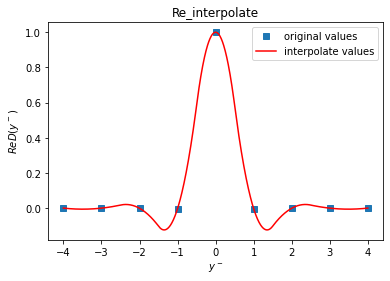

In [ ]:
plot1 = plt.plot(ym, Re_data, 's',label='original values')
plot2 = plt.plot(coti_ym, num_Re_inpol, 'r',label='interpolate values')
plt.xlabel('$y^-$')
plt.ylabel('$ReD(y^-)$')
plt.legend(loc="upper right")
plt.title('Re_interpolate')
plt.show()

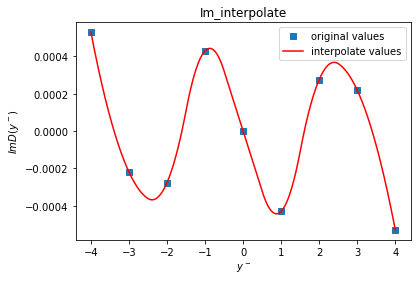

In [ ]:
plot1 = plt.plot(ym, Im_data, 's',label='original values')
plot2 = plt.plot(coti_ym, num_Im_inpol, 'r',label='interpolate values')
plt.xlabel('$y^-$')
plt.ylabel('$ImD(y^-)$')
plt.legend(loc="upper right")
plt.title('Im_interpolate')
plt.show()

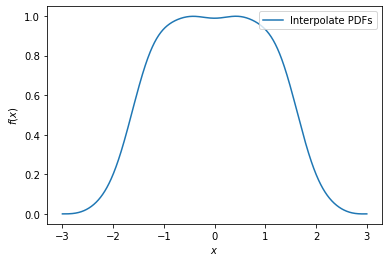

In [ ]:
coti_x=np.linspace(-3,3,1000)
inpol_PDFs=np.zeros(len(coti_x))
for i in range(len(coti_x)):
    inpol_PDFs[i]=np.real((coti_ym[1]-coti_ym[0])*np.dot(np.exp(-1j*P_mass*coti_ym*coti_x[i]),(num_Re_inpol+1j*num_Im_inpol)))

plot1 = plt.plot(coti_x, inpol_PDFs,label='Interpolate PDFs')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(loc="upper right")
plt.show()

In [ ]:
np.savetxt(fname='/home/lty/yin_research/NJL_PDF_code/NJL_PDF_result/posN18ma08g1_vac.txt',X=Re_data+1j*Im_data)

In [ ]:
P_mass

2.3820502713276355

In [ ]:
np.dot(np.conjugate(psi2),ham.dot(psi2))

(-2.4500000000000597+0j)

In [ ]:
[1,2]==[1,2]

True